In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
INPUT_DIR = "/work/signate_practice/football_forecasting/data"
sns.set()
import warnings
import japanize_matplotlib
import re
warnings.filterwarnings("ignore")
os.chdir(INPUT_DIR)

In [2]:
train = pd.read_csv("train.csv")
train_add = pd.read_csv("train_add.csv")
condition = pd.read_csv("condition.csv")
condition_add = pd.read_csv("condition_add.csv")
stadium = pd.read_csv("stadium.csv")
test = pd.read_csv("test.csv")

In [3]:
train = pd.concat([train, train_add])
condition = pd.concat([condition, condition_add])

In [4]:
print(train.shape)
print(test.shape)
print(condition.shape)

(1953, 11)
(313, 10)
(2304, 31)


In [5]:
train = pd.merge(train, condition, on="id", how="left")
test = pd.merge(test, condition, on="id", how="left")
train = pd.merge(train, stadium, left_on="stadium", right_on="name", how="left")
test = pd.merge(test, stadium, left_on="stadium", right_on="name", how="left")

In [6]:
train = train.drop("name", axis=1)
test = test.drop("name", axis=1)
print(train.shape)
train = train[train["y"] > 0]
print(train.shape)

(1953, 43)
(1952, 43)


In [7]:
combine = pd.concat([train, test])

In [8]:
def get_month(x):
    return int(x[0:2])
def get_week(x):
    return x[6:7]
def get_match(x):
    return int(x[x.find("第")+1:x.find("節")])
def get_humidity(x):
    return int(x[:-1]) / 100
def get_first_weather(x):
    return x[0]
def get_num(x):
    return len(x.split("／"))
def get_prefecture(x):
    if re.search("県", x):
        return x[:x.find("県")+1]
    elif re.search("都", x):
        return x[:x.find("都")+1]
    elif re.search("府", x):
        return x[:x.find("府")+1]
    elif re.search("道", x):
        return x[:x.find("道")+1]

In [9]:
combine["month"] = combine["gameday"].apply(get_month)
combine["week"] = combine["gameday"].apply(get_week)
combine["match_num"] = combine["match"].apply(get_match)
combine["humidity"] = combine["humidity"].apply(get_humidity)
combine["main_weather"] = combine["weather"].apply(get_first_weather)
combine["tv_num"] = combine["tv"].apply(get_num)
combine["prefecture"] = combine["address"].apply(get_prefecture)

In [10]:
combine["di"] = 0.81*combine["temperature"]+0.01*combine["humidity"]*(0.99*combine["temperature"]-14.3)+46.3

In [11]:
combine["away"] = combine["away"].replace("ザスパ草津", "ザスパクサツ群馬")
combine["home"] = combine["home"].replace("ザスパ草津", "ザスパクサツ群馬")

In [12]:
def whether_saturday_or_not(x):
    if x == "土":
        return 1
    else:
        return 0
    
def sun_or_rain(x):
    if x == "晴" or x == "曇":
        return 0
    else:
        return 1
    


In [13]:
combine["Saturday"] = combine["week"].apply(whether_saturday_or_not)
# combine["sun_or_rain"] = combine["main_weather"].apply(sun_or_rain)
# combine["last_match"] = 0
# combine["last_match"][(combine["match_num"] == 33) | (combine["match_num"] == 34) & (combine["stage"] == "Ｊ１")] = 1
# combine["last_match"][(combine["match_num"] == 41) | (combine["match_num"] == 42) & (combine["stage"] == "Ｊ２")] = 2
combine["score_diff"] = combine["home_score"] - combine["away_score"]

# combine["forlan"] = 0
# combine["forlan"][(combine["away"] == "セレッソ大阪") & (combine["year"] == 2014)] = 999

In [14]:
# import math
# def get_abs(x):
#     return np.abs(x)
# combine["score_diff"] = combine["score_diff"].apply(get_abs)

# def high_diff(x):
#     if x >= 4:
#         return 0
#     else:
#         return 1
# combine["high_diff_score"] = combine["score_diff"].apply(high_diff)



In [15]:
drop_column = ["id", "home_team", "away_team", "home_01", 
                "home_02", "home_03", "home_04", "home_05", "home_06", "home_07", "home_08", "home_09",
                "home_10", "home_11","away_01", "away_02", "away_03", "away_04", "away_05", "away_06",
                "away_07", "away_08", "away_09", "away_10", "away_11"]
combine = combine.drop(columns=drop_column, axis=1)

In [16]:
combine.shape

(2265, 27)

In [17]:
remove_column = ["match", "week", "main_weather", "stage", "prefecture", "stadium", "gameday", "time", "home", "away", "weather", 
                 "address", "referee", "tv", "temperature", "humidity", 'di', "away"]
df = combine.drop(columns=remove_column, axis=1)

In [18]:
train.shape

(1952, 43)

In [19]:
train = df.iloc[:1952, :]
test = df.iloc[1952:, :]

In [20]:
print(train.shape)
print(test.shape)

(1952, 10)
(313, 10)


In [21]:
train["y"].isnull().sum()

0

In [22]:
X = train.drop(["y"], axis=1)
Y = train["y"]
test_x = test.drop(["y"], axis=1)

In [23]:
print(X.shape)
print(Y.shape)

(1952, 9)
(1952,)


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [25]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1464, 9) (488, 9) (1464,) (488,)


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor as lgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [58]:
train_data = lgb.Dataset(X_train, y_train)
eval_data = lgb.Dataset(X_test, y_test, reference=train_data)

In [59]:
params = {
    "task" : "train",
    "boosting_type" : "gbdt",
    "objective" : "regression",
    "verbose" : 2,
}

In [60]:
gbm = lgb.train(
params,
train_data,
valid_sets=eval_data,
num_boost_round=100,
verbose_eval=5)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.153689
[LightGBM] [Debug] init for col-wise cost 0.000021 seconds, init for row-wise cost 0.002525 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 143
[LightGBM] [Info] Number of data points in the train set: 1464, number of used features: 9
[LightGBM] [Info] Start training from score 10794.643443
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 9
[5]	valid_0's l2: 3.10

In [61]:
preds = gbm.predict(X_test)
y_pred = []
for x in preds:
    y_pred.append(np.argmax(x))
    

In [62]:
np.sqrt(mean_squared_error(y_test, y_pred))

12678.230472908288

In [27]:
lr = LGBMRegressor()
lr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [28]:
y_pred = lr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

3726.772995674591

In [29]:
pred = lr.predict(test_x)

In [30]:
submission = pd.read_csv("sample_submit.csv", header=None)
submission[1] = pred

In [31]:
submission.head()

,0,1
0,15822,17354.529199
1,15823,14704.408850
2,15824,39725.387573
3,15825,13712.262128
4,15827,27489.195663


In [32]:
os.chdir("/work/signate_practice/football_forecasting/output")

In [33]:
submission.to_csv("submission.csv", index=False)

In [34]:
importances = pd.DataFrame({"feature":lr.feature_name_,
                           "importance":lr.feature_importances_})
importances.groupby("feature").agg({"importance":"mean"}).sort_values("importance", ascending=False).head(30)

,importance
feature,
capa,1201
match_num,621
month,291
away_score,194
score_diff,177
year,148
Saturday,126
home_score,122
tv_num,120


Text(0, 0.5, 'prediction')

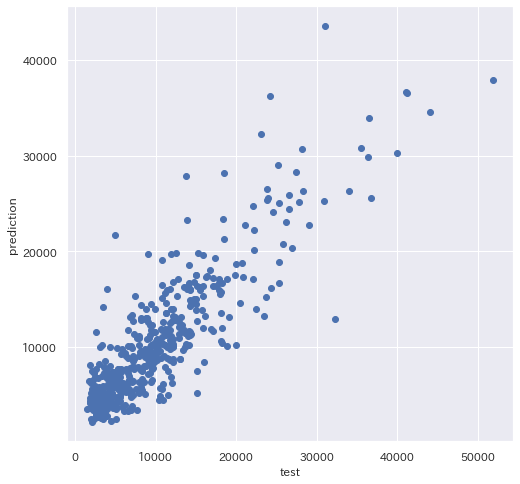

In [35]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred)
plt.xlabel("test")
plt.ylabel("prediction")

In [36]:
y_train_pred = lr.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
y_test_pred = lr.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(rmse_train, rmse_test)
print(lr.score(X_train, y_train), lr.score(X_test, y_test))

2687.596892169677 3726.772995674591
0.8940163577132011 0.7588387090456263


In [37]:
df.head()

,y,year,home_score,away_score,capa,month,match_num,tv_num,Saturday,score_diff
0,18250.0,2012,1,0,19694,3,1,4,1,1
1,24316.0,2012,1,0,40000,3,1,4,1,1
2,17066.0,2012,2,3,21000,3,1,4,1,-1
3,29603.0,2012,1,0,50000,3,1,4,1,1
4,25353.0,2012,0,0,39232,3,1,4,1,0


In [38]:
combine.corr()

,y,year,home_score,away_score,temperature,humidity,capa,month,match_num,tv_num,di,Saturday,score_diff
y,1.000000,0.003211,0.056229,0.018226,-0.028072,-0.100557,0.688290,0.105861,-0.044138,0.142387,-0.028146,0.407708,0.028491
year,0.003211,1.000000,-0.006051,-0.000105,0.000113,-0.118495,0.021823,0.005895,-0.019275,-0.470406,-0.000187,0.096342,-0.004339
home_score,0.056229,-0.006051,1.000000,-0.002569,0.017226,0.058687,0.034705,0.067138,0.054313,0.003447,0.017323,0.060839,0.730582
away_score,0.018226,-0.000105,-0.002569,1.000000,0.014753,0.041131,-0.011384,0.002784,-0.004253,-0.005325,0.014880,0.017015,-0.684699
temperature,-0.028072,0.000113,0.017226,0.014753,1.000000,0.183433,-0.033814,0.312475,0.363575,-0.119889,0.999996,0.017501,0.002481
humidity,-0.100557,-0.118495,0.058687,0.041131,0.183433,1.000000,-0.068474,0.263755,0.265234,-0.024956,0.185371,-0.025631,0.014687
capa,0.688290,0.021823,0.034705,-0.011384,-0.033814,-0.068474,1.000000,0.016674,-0.082696,0.077168,-0.033922,0.236585,0.033067
month,0.105861,0.005895,0.067138,0.002784,0.312475,0.263755,0.016674,1.000000,0.955042,-0.098569,0.312903,0.009254,0.047031
match_num,-0.044138,-0.019275,0.054313,-0.004253,0.363575,0.265234,-0.082696,0.955042,1.000000,-0.117424,0.363919,-0.115151,0.042489
tv_num,0.142387,-0.470406,0.003447,-0.005325,-0.119889,-0.024956,0.077168,-0.098569,-0.117424,1.000000,-0.119944,0.050150,0.006148
